# Automated classification of SMP profiles
*Josh King, Environment and Climate Change Canada, 2019*


In this section we deploy an automated method to classify the SMP transect profiles. The method applies off-the-shelf tools from [scikit-learn](https://scikit-learn.org) to construct a fairly simple support vector machine. Others have shown that it is possible to improve classification accuracy with a larger parameter space ([i.e. Havens et al., 2013]( https://ieeexplore.ieee.org/abstract/document/6377289)).


In [1]:
# Import community packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
plt.rcParams["font.family"] = "Times New Roman"
import matplotlib.cm as cm
import pickle
import os
from scipy.stats import mode, boxcox

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit
from sklearn.metrics import classification_report, accuracy_score, make_scorer, r2_score
from sklearn.svm import SVC  
from sklearn import preprocessing

from snowmicropyn import Profile, loewe2012 #SLF python SMP package
from smpfunc import preprocess #SMP helper functions

# Seed to replicate paper results
RANDOM_SEED = 2019

os.makedirs('./output/sites', exist_ok=True)

In [2]:
# Load all SMP transect profiles
def load_smp(smp_file):
    p = Profile.load(smp_file)
    p = preprocess(p, smoothing = 0)
    ground  = p.detect_ground()
    surface  = p.detect_surface()
    return p

In [3]:
# Load results from Parts 1 and 2
density_coeffs = pickle.load(open('./output/density_k19b_coeffs.pkl', 'rb'))
result = pd.read_pickle('./output/smp_pit_filtered.pkl')
result = result.assign(force_log=np.log(result['force_median']))
result.head(1)

,count_samp,mean_samp,median_samp,stdev_samp,index,ID,TOP,BOTTOM,RHO,NOTES,TYPE,relative_height,l,force_median,error,campaign,ice_type,lat,long,force_log
0,31,584.201003,617.731699,66.040178,209,24,18.0,11.5,442.5,-9999,R,15.0,0.172577,10.598897,141.701003,e,f,79.96301,-86.00111,2.36075


## Create input for the SVM

In [4]:
# Subset the test-train dataset with selected inputs
regression_vars = ['relative_height', 'l', 'force_median', 'TYPE']
svm_dat = result[regression_vars]
y = svm_dat['TYPE']
X = svm_dat.drop('TYPE', axis=1)

# Uses a stratified shuffle to make sure we get at least a few rounded samples in each train/test split
# see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html
stratified_shuffle = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=RANDOM_SEED)
stratified_shuffle.get_n_splits(X, y)

# Initialize the classifier
svclassifier = SVC(kernel='linear', gamma='scale', probability = True)

In [5]:
# Accuracy reporting using the 10-fold stratified shuffle
scores = cross_val_score(svclassifier,  preprocessing.scale(X), y, cv = stratified_shuffle)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

Accuracy: 0.76 (+/- 0.05)


In [6]:
# Train on all available data and save
svclassifier.fit(X, y)
filename = './output/svm_layer_model.sav'
pickle.dump(svclassifier, open(filename, 'wb'))

In [7]:
# This function handles classification and stucturing of data type outputs for SMP profiles in the dataset
# Input:
#   profile: a pandas dataframe structured as data={'relative_height': sn.distance, 'l': sn.L2012_L, 'force_median': sn.force_median}
#   classifier: sklearn.svm.classes.SVC 

def classify_profile(profile, classifier):
    temp_profile = profile.copy()
    
    profile_prediction = classifier.predict(temp_profile)
    profile_prediction[profile_prediction=='R'] = 1
    profile_prediction[profile_prediction=='F'] = 2
    profile_prediction[profile_prediction=='H'] = 3
    
    temp_profile['layer_type'] = profile_prediction.astype(int)
    
    #Layers must be at least 1 cm
    temp_profile['layer_type'] =  temp_profile['layer_type'].rolling(window=3, min_periods=1).apply(lambda x: mode(x)[0]).values.astype(int)
    temp_profile['layer_label'] =  temp_profile['layer_type']
    
    temp_profile.loc[temp_profile['layer_type'] == 1, 'layer_label'] = 'R'
    temp_profile.loc[temp_profile['layer_type'] == 2, 'layer_label'] = 'F'
    temp_profile.loc[temp_profile['layer_type'] == 3, 'layer_label'] = 'H'

    return temp_profile

### Example profile classified
Using independent snow pit information to evaluate classification. The selected profile is on MYI near Eureka.

In [8]:
smp_profile = './data/SMP/Calibration/S34M0649.pnt'
p = Profile.load(smp_profile)
p = preprocess(p, 0)
ground  = p.detect_ground()
surface  = p.detect_surface()
profile_height = ground-surface
sn = loewe2012.calc(p.samples_within_snowpack(), window=5)

In [9]:
# Estimate density
log_force_median = np.log(sn.force_median)
l = sn.L2012_L
density = density_coeffs[0] + density_coeffs[1] * log_force_median + density_coeffs[2] * log_force_median * l + density_coeffs[3] * l

In [10]:
# Restructure data and classify
svm_df = pd.DataFrame(data={'relative_height': sn.distance, 'l': sn.L2012_L, 'force_median': sn.force_median})
profile_prediction = classify_profile(svm_df, svclassifier)

In [11]:
# Import the international classification of snow symbols and
# set up visuals
prop = FontProperties()
prop.set_file('./data/SnowSymbolsIACS.ttf')
prop.set_size(20)
colors = ['#00FF00', '#FFB6C1', '#ADD8E6', '#0000FF']

layers = np.abs(np.diff(profile_prediction['layer_type']))
transitions = np.insert(np.argwhere(layers>=1).ravel(),0,0,axis = 0)
transitions = np.insert(transitions,len(transitions),len(profile_prediction['relative_height'])-2,axis = 0)

# Hardcoded layering from the pit sheets
obs_interfaces = np.array([61,57,53,44,30.5,13,3])
obs_layer_heights = np.abs(obs_interfaces - obs_interfaces.max())*10
obs_layer_symbols = ['v','y','z','D','D','F','F']

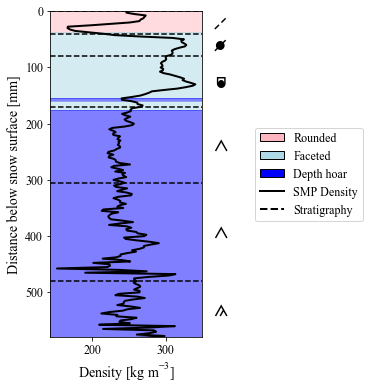

In [12]:
# Paper figure 6  with caption
# 'Automated classification on a SMP profile. SMP derived snow density (Black line)
#  is overlaid on the automated classification separated as rounded, faceted, or depth hoar. 
#  Horizontal dashed lines show the heights of snow pit observed stratigraphy at the same location. 
#  Snow pit layer observations are shown as standardized symbols to the right of each layer.'
axis_value_size = 12
axis_label_size = 14

f, (ax1, ax2)= plt.subplots(1, 2, sharey=False, figsize=(6,6))
ax1.tick_params(axis='both', which='major', labelsize=axis_value_size)
ax1.plot(density, profile_prediction.relative_height, color = 'k', zorder=1000, linewidth=2)
ax2.axis('off')
ax1.set_ylim(0,580)
ax1.invert_yaxis()
ax1.set_ylabel('Distance below snow surface [mm]',fontsize=axis_label_size)
ax1.set_xlabel('Density [kg m$\mathregular{^{-3}}$]',fontsize=axis_label_size)

# Colour in the layers
for l in np.arange(0, len(transitions)-1):
    layer_class = int(profile_prediction['layer_type'][transitions[l]+1])
    polypatch = ax1.axhspan(profile_prediction['relative_height'][transitions[l]], 
                            profile_prediction['relative_height'][transitions[l+1]], 
                            alpha=0.5, color=colors[layer_class])

# Add in the layer type symbols
for l in np.arange(0,len(obs_layer_heights)-1):
    layer_height_symbol = (obs_layer_heights[l+1] - (obs_layer_heights[l+1] - obs_layer_heights[l])/2)+10
    ax1.text(360, layer_height_symbol, obs_layer_symbols[l], fontproperties=prop)
    ax1.axhline(obs_layer_heights[l], color = 'k', alpha =1, zorder=500, linestyle='dashed')
    
legend_elements = [
                   Patch(facecolor='#FFB6C1', edgecolor='k',
                         label='Rounded'),
                   Patch(facecolor='#ADD8E6', edgecolor='k',
                         label='Faceted'),
                   Patch(facecolor='#0000FF', edgecolor='k',
                         label='Depth hoar'),
                   Line2D([0], [0], color='k', lw=2, label='SMP Density'),
                   Line2D([0], [0], color='k', lw=2, linestyle='dashed', label='Stratigraphy')]

ax1.legend(handles=legend_elements,loc='center', bbox_to_anchor=(1.7, 0.5), ncol=1,  fontsize=axis_value_size)

f.savefig('./output/figures/Fig6_class_lowres.png', format='png')

# Classifiy all the smp transect measurement

In [13]:
# import all the site directories to be processed
site_list = []
for dirname, dirnames, filenames in os.walk('.\data\SMP\Sites'):
    # print path to all subdirectories first.
    for subdirname in dirnames:
        if not subdirname.startswith('.'):
            site_list.append(os.path.join(dirname, subdirname))

In [14]:
# Function to process sites from raw SMP profiles to density and aggregate stats
expected_classes = ['F', 'R', 'H'] # Some pits don't have all classes so we check

def process_site(directory, classifier, coeffs, window_size = 5):
    site_measurement_df = pd.DataFrame()
    site_summary_df = pd.DataFrame()
    file_list = []
    site_name = directory.split('\\')[-1]
    ice_type = directory.split('\\')[-1][-3:] 

    for file in os.listdir(directory):
        if file.lower().endswith(".pnt"):
            file_list.append(os.path.join(directory, file))
    print("{} has {} SMP files to process... ".format(site_name, len(file_list)), end = '')
    
    smp_data = [load_smp(file) for file in file_list]
    
    for p in smp_data:
        smp_penetration = p.ground - p.surface
        sn = loewe2012.calc(p.samples_within_snowpack(), window=window_size)
        sn_df = pd.DataFrame(data={'relative_height': sn.distance, 
                                   'l': sn.L2012_L, 
                                   'force_median': sn.force_median})
        sn_df =  classify_profile(sn_df, svclassifier)
        
        sn_df['site_name'] = site_name
        sn_df['file_name'] = p.name
        sn_df['density'] = coeffs[0] + coeffs[1] * np.log(sn_df['force_median']) \
                         + coeffs[2] * np.log(sn_df['force_median']) * sn_df['l'] \
                         + coeffs[3] * sn_df['l']
        
        
        rho_type_mean = sn_df.groupby(['layer_label'])['density'].mean()
        rho_type_std = sn_df.groupby(['layer_label'])['density'].std()
        rho_type_fract = sn_df.groupby(['layer_label'])['density'].count()/len(sn_df)
        
        for l_type in expected_classes:
            if not l_type in rho_type_mean.index.values:
                rho_type_mean[l_type] = np.nan
                rho_type_std[l_type] = np.nan
                rho_type_fract[l_type]  = 0
       
        rho_weighted_mean = (rho_type_mean*rho_type_fract).sum()
        
        summary_df = pd.DataFrame(data={'file_name': p.name, 
                                        'site_name': site_name, 
                                        'ice_type': ice_type,
                                        'latitude': p.coordinates[0],
                                        'longitude': p.coordinates[1],
                                        'penetration': smp_penetration,
                                        'density_f': rho_type_mean['F'],
                                        'density_h': rho_type_mean['H'],
                                        'density_r': rho_type_mean['R'],
                                        'fraction_f': rho_type_fract['F'],
                                        'fraction_h': rho_type_fract['H'],
                                        'fraction_r': rho_type_fract['R'],
                                        'mean_weighted_density': rho_weighted_mean},index=[0])
        site_summary_df = site_summary_df.append(summary_df, ignore_index=True)
        site_measurement_df = site_measurement_df.append(sn_df, ignore_index=True)
    
   
    print("Done")
    return site_summary_df, site_measurement_df

In [17]:
for site in site_list:
    ssum, sdata = process_site(site, svclassifier, density_coeffs)
    pickle.dump(ssum, open('./output/sites/Summary_' + ssum.head(1)['site_name'].astype(str)[0] + '.sav', 'wb'))
    pickle.dump(sdata, open('./output/sites/Data_' + ssum.head(1)['site_name'].astype(str)[0]+ '.sav', 'wb'))

Alert_2_MYI has 12 SMP files to process... Done
Alert_3_MYI has 12 SMP files to process... Done
Alert_5_MYI has 12 SMP files to process... Done
Alert_6_MYI has 12 SMP files to process... Done
Alert_7_MYI has 3 SMP files to process... Done
Alert_8_MYI has 12 SMP files to process... Done
Eureka_1_FYI has 31 SMP files to process... Done
Eureka_2_FYI has 41 SMP files to process... Done
Eureka_3_FYI has 70 SMP files to process... Done
Eureka_4_FYI has 70 SMP files to process... Done
Eureka_5_MYI has 85 SMP files to process... Done
Eureka_6_FYI has 92 SMP files to process... Done
Eureka_7_FYI has 100 SMP files to process... Done
Eureka_8_MYI has 63 SMP files to process... Done
